## Init

In [351]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [352]:
# External imports
import numpy as np
import cPickle as pickle
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import fmin
# Internal imports
import utils
import okcupidio

In [353]:
# load data if necessary:
df = pickle.load(open('imputed_df.p', 'r'))
rawDF = pickle.load(open('rawdf.p'))
filteredDF = pickle.load(open('filtered_df.p', 'r'))
x, y, names = pickle.load(open('dataset.p'))
xtrain, ytrain, trainInd = pickle.load(open('data_train.p', 'r'))
xtest, ytest, testInd = pickle.load(open('data_test.p', 'r'))
w, w0, names = pickle.load(open('regression_results.p','r'))

# Feature Analysis

In [354]:
# Sort regression weights by importance (or lack thereof)
iSort = abs(w.flatten()).argsort()
wSorted = w[iSort].flatten()
namesSorted = names[iSort]
weightRank = {}
for i in range(len(wSorted)):
    print i, wSorted[i], namesSorted[i]
    weightRank[namesSorted[i]] = i

0 1.09710062992e-09 speaks_latvian
1 -1.16382962023e-05 speaks_serbian
2 2.13281682121e-05 education_ph.d program
3 5.53266859017e-05 sign_taurus
4 -7.65594214695e-05 speaks_lisp
5 8.14712085875e-05 speaks_georgian
6 -8.25810210317e-05 education_law school
7 9.42571421528e-05 diet_strictly halal
8 0.000104942468097 diet_mostly halal
9 0.000106935015331 speaks_catalan
10 0.000113240991796 speaks_swahili
11 -0.000115505077997 speaks_ukrainian
12 -0.00014693260759 speaks_tamil
13 -0.000151220807358 speaks_albanian
14 -0.000173084427174 smokes_when drinking
15 0.000198594187056 religion_agnosticism
16 -0.000216033191015 speaks_esperanto
17 0.00022339493242 education_working on med school
18 0.000243581906163 sign_aries
19 -0.000249415439822 speaks_mongolian
20 0.000286287233539 speaks_finnish
21 0.000304679893874 education_med school
22 -0.000345185237712 sign_cancer
23 0.000354184664165 sign_pisces
24 -0.000365212338593 likes_dogs
25 -0.000373702972664 speaks_icelandic
26 0.00037512352536

In [355]:
# Speaking c++ is a predictor of being male
cppDF = rawDF[rawDF['speaks_c++'].astype(bool)]
mu = cppDF['sex_m'].mean()
err = cppDF['sex_m'].std()/np.sqrt(len(cppDF))
print 'Average c++ speaking male fraction: {0} +/- {1}'.format(mu, err)

Average c++ speaking male fraction: 0.907488986784 +/- 0.00785395371868


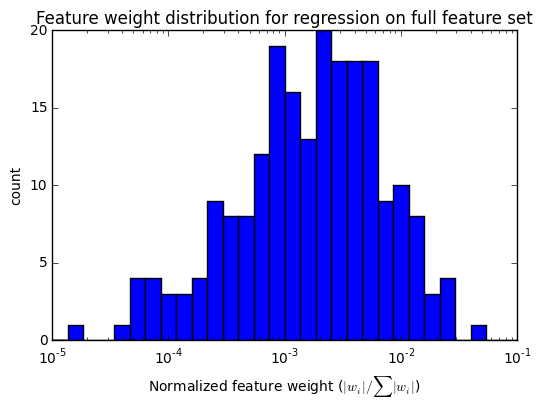

In [356]:
bins = np.logspace(-5, -1, 30 + 1)
plt.hist(abs(w)/abs(w).sum(), bins);
plt.gca().set_xscale('log')
plt.xlabel(r'Normalized feature weight ($|w_i|/\sum|w_i|$)')
plt.ylabel('count')
plt.title('Feature weight distribution for regression on full feature set')
plt.savefig('figures/feature_weight_dist.pdf')

# Alter features

In [357]:
newFeatsDF = rawDF.copy(deep=True)

In [358]:
def dropcolumns(df, columns, verbose=True):
    for col in columns:
        if col in df.columns:
            df.drop(col, 1, inplace=True)
            if verbose:
                print 'dropping ', col

## Astrological signs

In [359]:
# Filter signs
signs = [col for col in rawDF.columns if col[0:5] == 'sign_']
signs = [col for col in signs if 'matters' not in col]
# print signs
signDF = rawDF[signs]
signResponse = np.zeros(rawDF.shape[0], dtype=bool)
mask = signDF[signs[0]].notnull().values
signResponse[mask] = True
# Drop signs
print 'fraction of responders to astrological sign: ', signResponse.mean()
dropcolumns(newFeatsDF, signs)
# Include responses
newFeatsDF['sign_responded'] = signResponse.astype(float)

fraction of responders to astrological sign:  0.815567343943
dropping  sign_aquarius
dropping  sign_aries
dropping  sign_cancer
dropping  sign_capricorn
dropping  sign_gemini
dropping  sign_leo
dropping  sign_libra
dropping  sign_pisces
dropping  sign_sagittarius
dropping  sign_scorpio
dropping  sign_taurus
dropping  sign_virgo


## Language

In [360]:
languages = [col for col in rawDF.columns if 'speaks_' in col]
# print languages
languageDF = rawDF[languages]
# Remove speaks c++ (which is a predictor of being male)
languages.remove('speaks_c++')
english = languageDF['speaks_english']
numlang = languageDF.sum(axis=1)
languages.remove('speaks_english')
dropcolumns(newFeatsDF, languages, verbose=False)
newFeatsDF['num_languages'] = numlang

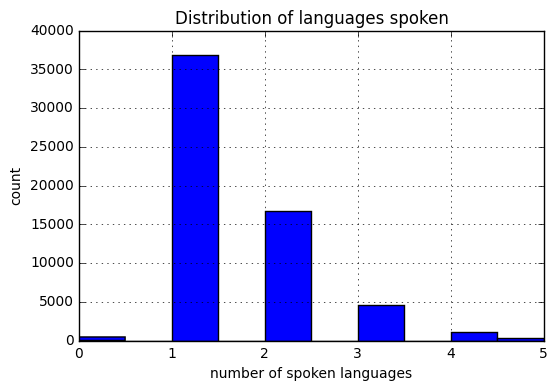

In [361]:
newFeatsDF['num_languages'].hist()
plt.xlabel('number of spoken languages')
plt.ylabel('count')
plt.title('Distribution of languages spoken')
plt.savefig('figures/num_langs_dist.pdf')

## Education

In [362]:
i2 = []
name2 = []

for i, name in enumerate(namesSorted):
    if name in newFeatsDF.columns:
        i2.append(i)
        name2.append(name)
        if 'education_' in name:
            print i, name

2 education_ph.d program
6 education_law school
17 education_working on med school
21 education_med school
49 education_dropped out of ph.d program
54 education_dropped out of masters program
69 education_dropped out of med school
75 education_graduated from ph.d program
81 education_working on law school
102 education_graduated from law school
103 education_college/university
105 education_space camp
110 education_working on space camp
113 education_dropped out of law school
116 education_two-year college
124 education_working on high school
125 education_graduated from med school
131 education_masters program
132 education_dropped out of two-year college
136 education_dropped out of space camp
139 education_high school
140 education_working on ph.d program
155 education_graduated from space camp
161 education_dropped out of high school
168 education_working on college/university
171 education_working on masters program
178 education_graduated from college/university
179 education_gra

In [363]:

educationDF = rawDF.filter(like='education_')
spaceDF = educationDF.filter(like='space')
spaceMask = (spaceDF ==1).any(axis=1)
dropcolumns(educationDF, spaceDF.columns)
educationDF[spaceMask] = np.nan

dropping  education_dropped out of space camp
dropping  education_graduated from space camp
dropping  education_space camp
dropping  education_working on space camp


### Space camp

In [364]:
# Handle space camp
dropcolumns(newFeatsDF, spaceDF.columns)
newFeatsDF['spacecamp'] = spaceMask.astype(float)

dropping  education_dropped out of space camp
dropping  education_graduated from space camp
dropping  education_space camp
dropping  education_working on space camp


### Actual education

In [365]:
rankedEducation = ['education_dropped out of high school',
'education_high school',
'education_working on high school',
'education_graduated from high school',
'education_dropped out of two-year college',
'education_dropped out of college/university',
'education_two-year college',
'education_working on two-year college',
'education_graduated from two-year college',
'education_college/university',
'education_working on college/university',
'education_graduated from college/university',
'education_dropped out of law school',
'education_dropped out of masters program',
'education_dropped out of med school',
'education_dropped out of ph.d program',
'education_working on masters program',
'education_working on law school',
'education_working on med school',
'education_working on ph.d program',
'education_law school',
'education_masters program',
'education_med school',
'education_ph.d program',
'education_graduated from law school',
'education_graduated from masters program',
'education_graduated from med school',
'education_graduated from ph.d program']
iEducationRank = np.arange(len(rankedEducation))
eduRankDict = {k: v for k, v in zip(rankedEducation, iEducationRank)}

In [366]:
# Get the education level (str) attained
vals = educationDF.values
cols = np.zeros(len(educationDF), dtype=int)
isnull = educationDF.isnull().all(axis=1).values
cols[isnull] = 0
cols[~isnull] = vals[~isnull].argmax(1)
colArray = np.array(educationDF.columns.tolist())
education_name = colArray[cols]
# Use the rankings above to assign a value to education level
education_level = np.array([eduRankDict[level] for level in education_name])
# Setup data frame
dropcolumns(newFeatsDF, educationDF.columns)
newFeatsDF['education_level'] = education_level
newFeatsDF.loc[isnull, 'education_level'] = np.nan

dropping  education_college/university
dropping  education_dropped out of college/university
dropping  education_dropped out of high school
dropping  education_dropped out of law school
dropping  education_dropped out of masters program
dropping  education_dropped out of med school
dropping  education_dropped out of ph.d program
dropping  education_dropped out of two-year college
dropping  education_graduated from college/university
dropping  education_graduated from high school
dropping  education_graduated from law school
dropping  education_graduated from masters program
dropping  education_graduated from med school
dropping  education_graduated from ph.d program
dropping  education_graduated from two-year college
dropping  education_high school
dropping  education_law school
dropping  education_masters program
dropping  education_med school
dropping  education_ph.d program
dropping  education_two-year college
dropping  education_working on college/university
dropping  education_wor

## Save

In [367]:
pickle.dump(newFeatsDF, open('new_features_df.p', 'w'), 2)